In [1]:
!nvidia-smi

Wed May 19 00:06:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   41C    P0    29W / 250W |      0MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
import os, time
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset, replace_ImageToTensor) # 앞의 2개 --> mmdet/datasets/builder.py에 존재 / 마지막 1개 --> 
from mmdet.models import build_detector #mmdet/models/builder.py에 존재
from mmdet.apis import train_detector, single_gpu_test # mmdet/apis/train.py, test.py에 존재
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
from mmcv.runner import load_checkpoint
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np
import json#, wandb

## train part

In [2]:
classes = ("UNKNOWN", "General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")
# config file 들고오기
#cfg = Config.fromfile('../configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py')
#파일 교체 시 여기 이름 바꾸기
config_dir_name = 'hrnet'
config_file_name = 'faster_rcnn_hrnetv2p_w40_2x_coco_adam_optim_cosineAnnealing copy'
cfg = Config.fromfile('../configs/'+config_dir_name+'/'+config_file_name+'.py')

PREFIX = '/opt/ml/input/data/'

# dataset 바꾸기
cfg.data.train.classes = classes
cfg.data.train.img_prefix = PREFIX
cfg.data.train.ann_file = PREFIX + 'train.json'
cfg.data.train.pipeline[2]['img_scale'] = (512, 512)

cfg.data.val.classes = classes
cfg.data.val.img_prefix = PREFIX
cfg.data.val.ann_file = PREFIX + 'val.json'
cfg.data.val.pipeline[1]['img_scale'] = (512, 512)

cfg.data.test.classes = classes
cfg.data.test.img_prefix = PREFIX
cfg.data.test.ann_file = PREFIX + 'test.json'
cfg.data.test.pipeline[1]['img_scale'] = (512, 512)

cfg.data.samples_per_gpu = 16    #batch size
cfg.runner.max_epochs = 24

cfg.seed=42 #42로 고정
cfg.gpu_ids = [0]

cfg.model.roi_head.bbox_head.num_classes = 11

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)

##optimizer
cfg.optimizer = dict(type='Adam', lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0, amsgrad=False)


#working directory 이름 설정
option_name ='_(autoAug_crossEnt:_adma:_cosineAnnealing)'
working_dir_name = '../work_dirs/' + config_file_name + option_name +'_'+str(cfg.runner.max_epochs)
cfg.work_dir = working_dir_name


## wandb setting

In [3]:
group_name = 'hrnet'; project_name = 'gjtak'; run_name = config_file_name+ option_name +'_'+str(cfg.runner.max_epochs)
config_list = {
    'epoch' : cfg.runner.max_epochs,
    'batch_size' :  cfg.data.samples_per_gpu,
    'optimizer' : cfg.optimizer,
    'optimizer_config' : cfg.optimizer_config,
    'lr_config' : cfg.lr_config,
    'loss_cls' : cfg.model.rpn_head.loss_cls
}
cfg.log_config.hooks[1].init_kwargs['group']=group_name # group name(option)
cfg.log_config.hooks[1].init_kwargs['name'] = run_name # run name
cfg.log_config.hooks[1].init_kwargs['config'] = config_list # config

### config 저장

In [4]:
# config 객체 -> 파일(json)로 저장(저장 장소 = working directory와 같이)
#working directory 없으면 생성하기
try:
    if not os.path.exists(working_dir_name):
        os.makedirs(working_dir_name)
except OSError :
    print('Error: Creating directory :: ' + working_dir_name)

#cfg 객체 -> string(str이용) -> dict(eval이용) -> json 으로 저장
cfg_str = str(cfg)[str(cfg).find(')')+3:]
cfg_dict = eval(cfg_str)
with open(working_dir_name+'/config.json','w') as config_json_file :
    json.dump(cfg_dict, config_json_file, indent="\t")


In [5]:
#config 저장 확인
with open(working_dir_name+'/config.json', 'r') as f :
    json_data = json.load(f)
#json_data

In [6]:
model = build_detector(cfg.model)

2021-05-19 00:40:59,156 - mmdet - INFO - load model from: open-mmlab://msra/hrnetv2_w40
2021-05-19 00:40:59,157 - mmdet - INFO - Use load_from_openmmlab loader
2021-05-19 00:40:59,687 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: incre_modules.0.0.conv1.weight, incre_modules.0.0.bn1.weight, incre_modules.0.0.bn1.bias, incre_modules.0.0.bn1.running_mean, incre_modules.0.0.bn1.running_var, incre_modules.0.0.bn1.num_batches_tracked, incre_modules.0.0.conv2.weight, incre_modules.0.0.bn2.weight, incre_modules.0.0.bn2.bias, incre_modules.0.0.bn2.running_mean, incre_modules.0.0.bn2.running_var, incre_modules.0.0.bn2.num_batches_tracked, incre_modules.0.0.conv3.weight, incre_modules.0.0.bn3.weight, incre_modules.0.0.bn3.bias, incre_modules.0.0.bn3.running_mean, incre_modules.0.0.bn3.running_var, incre_modules.0.0.bn3.num_batches_tracked, incre_modules.0.0.downsample.0.weight, incre_modules.0.0.downsample.1.weight, incre_modules.0

In [7]:
datasets = [build_dataset(cfg.data.train)]

loading annotations into memory...
Done (t=3.76s)
creating index...
index created!


In [8]:
start = time.time()  # 시작 시간 저장
train_detector(model, datasets[0], cfg, distributed=False, validate=True)
print("time(sec) :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간(단위 : 초)

loading annotations into memory...
2021-05-19 00:41:12,728 - mmdet - INFO - Start running, host: root@a0934ebc062a, work_dir: /opt/ml/p3-ims-obd-hansarang/gjtak_works/Object Detection/code/mmdetection_trash/work_dirs/faster_rcnn_hrnetv2p_w40_2x_coco_adam_optim_cosineAnnealing copy_(autoAug_crossEnt:_adma:_cosineAnnealing)_24
2021-05-19 00:41:12,729 - mmdet - INFO - workflow: [('train', 1)], max: 24 epochs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
Done (t=0.89s)
creating index...
index created!
wandb: Currently logged in as: pstage3_det (use `wandb login --relogin` to force relogin)


0.0317, loss_cls: 0.1322, acc: 95.5762, loss_bbox: 0.1756, loss: 0.3456, grad_norm: 1.2731
2021-05-19 02:24:40,427 - mmdet - INFO - Epoch [21][140/164]	lr: 6.700e-05, eta: 0:12:19, time: 1.462, data_time: 0.021, memory: 19328, loss_rpn_cls: 0.0066, loss_rpn_bbox: 0.0280, loss_cls: 0.1216, acc: 95.9241, loss_bbox: 0.1614, loss: 0.3176, grad_norm: 1.2690
2021-05-19 02:24:54,977 - mmdet - INFO - Epoch [21][150/164]	lr: 6.700e-05, eta: 0:12:05, time: 1.455, data_time: 0.021, memory: 19328, loss_rpn_cls: 0.0073, loss_rpn_bbox: 0.0312, loss_cls: 0.1222, acc: 95.9167, loss_bbox: 0.1764, loss: 0.3371, grad_norm: 1.3073
2021-05-19 02:25:09,514 - mmdet - INFO - Epoch [21][160/164]	lr: 6.700e-05, eta: 0:11:51, time: 1.454, data_time: 0.020, memory: 19328, loss_rpn_cls: 0.0058, loss_rpn_bbox: 0.0270, loss_cls: 0.1217, acc: 95.8801, loss_bbox: 0.1637, loss: 0.3182, grad_norm: 1.3132
2021-05-19 02:25:15,383 - mmdet - INFO - Saving checkpoint at 21 epochs
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 655/655, 13.3

train/loss_rpn_cls,0.00495
train/loss_rpn_bbox,0.02762
train/loss_cls,0.10384
train/acc,96.53687
train/loss_bbox,0.15173
train/loss,0.28814
train/grad_norm,1.03267
learning_rate,0.0
momentum,0.9
_runtime,7191
_timestamp,1621392064


train/loss_rpn_cls,█▇▄▅▄▄▄▃▃▄▃▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss_rpn_bbox,██▆█▅▆▆▅▅▆▅▆▅▆▅▄▅▄▅▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▁▂▂
train/loss_cls,██▇█▆▇▇▆▆▆▅▆▆▆▆▅▅▅▅▅▄▅▅▄▃▃▃▃▂▃▂▂▂▁▁▁▁▁▁▁
train/acc,▂▂▂▁▂▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▅▅▅▅▆▆▆▆▇█████▇█
train/loss_bbox,██▇█▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▂▂
train/loss,██▆▇▆▆▆▅▅▆▅▅▅▅▅▅▅▄▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▂▁
train/grad_norm,▅█▄▆▄▄▃▃▃▃▂▃▃▃▃▂▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
learning_rate,▂▃▄▄▅▅▆▇▇█████▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


time(sec) : 7203.61523270607


## Inference part

In [9]:
epoch = cfg.runner.max_epochs
cfg.model.train_cfg = None

# checkpoint path
checkpoint_path = os.path.join(cfg.work_dir, f'epoch_{epoch}.pth')

In [10]:
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [11]:
model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu')

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

2021-05-19 02:43:53,313 - mmdet - INFO - load model from: open-mmlab://msra/hrnetv2_w40
2021-05-19 02:43:53,314 - mmdet - INFO - Use load_from_openmmlab loader
2021-05-19 02:43:53,826 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: incre_modules.0.0.conv1.weight, incre_modules.0.0.bn1.weight, incre_modules.0.0.bn1.bias, incre_modules.0.0.bn1.running_mean, incre_modules.0.0.bn1.running_var, incre_modules.0.0.bn1.num_batches_tracked, incre_modules.0.0.conv2.weight, incre_modules.0.0.bn2.weight, incre_modules.0.0.bn2.bias, incre_modules.0.0.bn2.running_mean, incre_modules.0.0.bn2.running_var, incre_modules.0.0.bn2.num_batches_tracked, incre_modules.0.0.conv3.weight, incre_modules.0.0.bn3.weight, incre_modules.0.0.bn3.bias, incre_modules.0.0.bn3.running_mean, incre_modules.0.0.bn3.running_var, incre_modules.0.0.bn3.num_batches_tracked, incre_modules.0.0.downsample.0.weight, incre_modules.0.0.downsample.1.weight, incre_modules.0

In [12]:
output = single_gpu_test(model, data_loader, show_score_thr=0.05)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 837/837, 13.7 task/s, elapsed: 61s, ETA:     0s

In [13]:
prediction_strings = []
file_names = []
coco = COCO(cfg.data.test.ann_file)
imag_ids = coco.getImgIds()

class_num = 11
for i, out in enumerate(output):
    prediction_string = ''
    image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
    for j in range(class_num):
        for o in out[j]:
            prediction_string += str(j) + ' ' + str(o[4]) + ' ' + str(o[0]) + ' ' + str(o[1]) + ' ' + str(
                o[2]) + ' ' + str(o[3]) + ' '
        
    prediction_strings.append(prediction_string)
    file_names.append(image_info['file_name'])


submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names

submission.to_csv(os.path.join(cfg.work_dir, 'submission_'+config_file_name+f'_{epoch}.csv'), index=None)
submission.head()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


,PredictionString,image_id
0,0 0.12568302 0.0 329.09802 95.84233 452.42456 ...,batch_01_vt/0021.jpg
1,1 0.5302323 0.0 238.16672 301.9677 457.86435 2...,batch_01_vt/0028.jpg
2,1 0.47653177 73.287704 160.78757 375.59515 387...,batch_01_vt/0031.jpg
3,0 0.051073387 343.72437 105.99895 373.03674 18...,batch_01_vt/0032.jpg
4,0 0.060457554 472.46594 271.8955 507.35394 291...,batch_01_vt/0070.jpg


## for inference result image

In [14]:
# build the model from a config file and a checkpoint file
# checkpoint path
epoch = cfg.runner.max_epochs
checkpoint_path = os.path.join(cfg.work_dir, f'epoch_{epoch}.pth')
model_for_img = init_detector(cfg, checkpoint_path, device='cuda:0')

Use load_from_local loader


In [19]:
# test a single image
'''
이미지 파일
batch v1 -> 6720, 1142, 0334
batch v2 -> 0454, 0351, 0368
batch 3 -> 0207, 0050, 0098
'''
img_dir_name = '01_vt/'; img_num = '0334' 
#img_dir_name = '03/'; img_num = '0207' 
img_path = PREFIX + '/batch_'+img_dir_name+ img_num + '.jpg'
result = inference_detector(model_for_img, img_path)

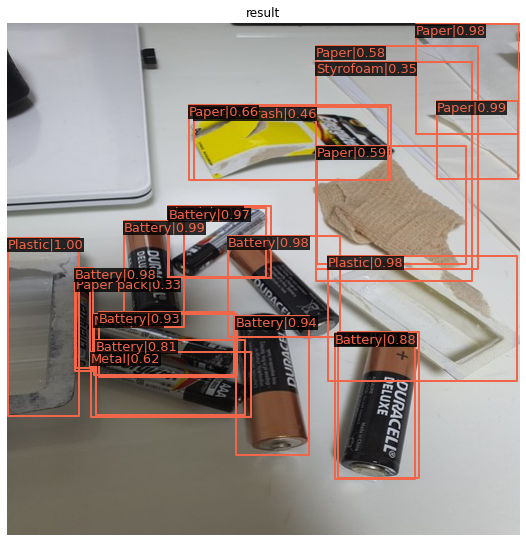

In [20]:
# show the results
show_result_pyplot(model_for_img, img_path, result)